# Analyse  MNIST structure using Variance-covariance matrix

- Assume distribution of images in image-cluster for each number can be approximated by multivariate normal distribution in (28*28=) 784-dimensional space
- On this assumtion, I'd like to seek a formula of probability distribution function of each image-cluster


- Assume pixel value of image $z = (z_1, z_2, ..., z_n)^T$ is determined by random variable $Z = (Z_1, Z_2, ..., Z_n)^T$


- Assume there is relationship between random variable $Z$ and $X$ s.t. $Z = A X + \mu$
  - $A$ is n*n matrix $A = (A_{ij})$
  - $X$ is random variable $X = (X_1, X_2, ..., X_n)^T$ 
  - $\mu$ is vector  $\mu = (\mu_1, \mu_2, ..., \mu_n)$
  - $X_i$ has probability density function $N(0,1)$, so,
   - probability density function of $X$ is  
     $f(x_1, ..., x_n) = \prod\limits_{i=1}^{n}{1 \over {\sqrt{2 \pi}}} exp(-{x_i^2 \over 2}) = {1 \over {\sqrt{2 \pi}}^n} exp(- \sum\limits_{i=1}^{n}{x_i^2 \over 2}) = {1 \over {\sqrt{2 \pi}}^n} exp(- {1 \over 2}x^T x)$
   - where variable $x = (x_1, x_2, ..., x_n)^T$ determined by random variable $X$


- Temporarily assume $A^{-1}$ exists 
 - So, $X = A^{-1}(Z - \mu)$
 - So, $d x_1 d x_2 ... d x_n = det(A^{-1}) d z_1 d z_2 ... d z_n$
 - So, $f(x_1, ..., x_n)d x_1 ... d x_n \\
    = {1 \over {\sqrt{2 \pi}}^n} exp(- {1 \over 2}x^T x) d x_1 d x_2 ... d x_n \\ 
    = {1 \over {\sqrt{2 \pi}}^n} exp(- {1 \over 2} \{A^{-1}(Z - \mu)\}^T \{A^{-1}(Z - \mu)\}) det(A^{-1}) d z_1 d z_2 ... d z_n \\
    = {1 \over {\sqrt{2 \pi}}^n det(A)} exp(- {1 \over 2} (Z - \mu)^T (A^T)^{-1} (A)^{-1} (Z - \mu)) ) d z_1 d z_2 ... d z_n \\
    = {1 \over {\sqrt{2 \pi}}^n det(A)} exp(- {1 \over 2} (Z - \mu)^T (A A^T)^{-1} (Z - \mu)) ) d z_1 d z_2 ... d z_n $
 - So, for probability density function $g(z_1, ..., z_n)$ of Z : 
   $g(z_1, ..., z_n)d z_1 d z_2 ... d z_n = f(x_1, ..., x_n)d x_1 ... d x_n \\
     = {1 \over {\sqrt{2 \pi}}^n det(A)} exp(- {1 \over 2} (Z - \mu)^T (A A^T)^{-1} (Z - \mu)) ) d z_1 d z_2 ... d z_n $ 
 - So, $g(z_1, ..., z_n) = {1 \over {\sqrt{2 \pi}}^n det(A)} exp(- {1 \over 2} (Z - \mu)^T (A A^T)^{-1} (Z - \mu)) ) $


- BTW, $A A^T$ (= $\Sigma$) can be computed from distribution of Z :
 - $E[Z] = E[A X + \mu] = A E[X] + \mu = 0 + \mu = \mu$
 - $V[Z] = E[(Z - \mu)^T (Z - \mu)] = E[(A X)^T (A X)] = E[(A X) (A X)^T]^T = E[A X X^T A^T]^T \\
    = (A E[X X^T] A^T)^T = (A (V[X] + E[X]) A^T)^T = (A (1 + 0) A^T)^T = (A A^T)^T = A A^T$
 - So, $A A^T$ (= $\Sigma$) can be numerically calculated as Variance-covariance matrix of Z: $V[Z] $ 


- When  $A^{-1}$ DOES NOT exists
 - $\Sigma$ can be numerically calculated as Variance-covariance matrix of Z: $V[Z] $ 
 - I'd like to calucate $A$ s.t. $A A^T = \Sigma$
 - $A$ can be caluculate as follows:
 - Calculate singular value decomposition s.t. $U s V = \Sigma$ where U, V:unitary, s:diagonal(singular values)
 - $A$ is calculated as $A = U r V$ where $r = s^{1/2}$

# Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

import math
import scipy
import scipy.stats

In [2]:
# print statistics of array and display array as image

def print_stat(a, str, show_image=True):
    print(str, ": shape=", a.shape, "min=", np.min(a), "max=", np.max(a), "mean=", np.mean(a),
          "std=", np.std(a), "rank=", np.linalg.matrix_rank(a), end=" ")
    if len(a.shape) <= 1:
        print()
        return
    if a.shape[0] == a.shape[1]:
        print("det=", np.linalg.det(a))
    else:
        print()
    if show_image:
        plt.imshow(a, interpolation="none")
        plt.colorbar()
        plt.show()

In [3]:
# extract base rows of matrix

def extract_base(a, threshold):
    n = len(a)
    
    i1 = -1
    for i in range(n):
        b1 = a[:,i]
        if np.max(np.abs(b1)) > threshold:
            i1 = i
            break
    if i1 == -1:
        print("ERROR: a is almost zero")
        return None, None, None
    print("extract_base(threshold=", threshold, ") : n=", n, "i1=", i1, "max=", np.max(a[:,i1]))
    
    bindex = [i1]
    b = a[:,i1][:,None]
    rank = 1
    for i in range(i1+1, n):
        nb = a[:,i]
        if np.max(np.abs(nb)) < threshold:
            continue
        ba = np.hstack((b, nb[:,None]))
        if np.linalg.matrix_rank(ba) > rank:
            bindex.append(i)
            b = ba
            rank += 1
    bindex = np.array(bindex)
    # print("rank=", rank)
    # print("bindex=", bindex)
    # print("b="); print(b) 

    return b, bindex, rank

In [4]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/g3doc/tutorials/mnist/input_data.py
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
# get sample data

num_all_sample = 50000
x_sample, y_sample = mnist.train.next_batch(num_all_sample)

x_sample_of_chars = []
for char in range(10):
    index = np.arange(num_all_sample)[y_sample[:,char] == 1]
    x_sample_of_char = x_sample[index]
    x_sample_of_chars.append(x_sample_of_char)

centers : shape= (10, 784) min= 0.0 max= 0.965245 mean= 0.131503 std= 0.20414 rank= 10 


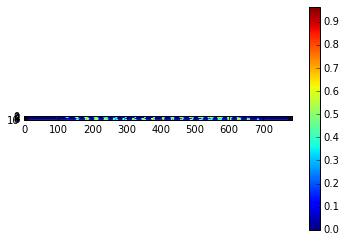

In [9]:
# Calculate centers of image-clusters of 0..9

centers = []
for i in range(10):
    x_sample = x_sample_of_chars[i]
    center = np.average(x_sample, axis=0)
    centers.append(center)
centers = np.array(centers)
print_stat(centers, "centers")

# Calculate and check variance-covariance matrix and A

In [10]:
# Calculate Variance-covariance matrix for each image-cluster
# Result: A * A.T = cov (because cov is symmetric => V = U.T => UrV(UrV).T=UsU.TUsU=UrU.T = cov)

As = []
for i in range(10):
    z = x_sample_of_chars[i]
    n = len(z)
    z = z.T
    u = centers[i]
    print("i=", i, " n=", n)
    
    # Calculate Variance-covariance matrix
    z0 = z - u[:, None]
#    print_stat(z0, "z0")
    cov = np.dot(z0, z0.T)/n
    print_stat(cov, "cov", show_image=False)

    # Calculate A from Variance-covariance matrix
    U, s, V = np.linalg.svd(cov, full_matrices=False)
    r = np.sqrt(s)
    A = np.dot(np.dot(U, np.diag(r)), V)
#    print_stat(A, "A")
    As.append(A)

    # check if A * A.T = cov
    print("max(abs(A * A.T - cov))=", np.max(np.max(np.dot(A, A.T) - cov)))
    print()


i= 0  n= 4950
cov : shape= (784, 784) min= -0.121196 max= 0.19758 mean= 0.00178741 std= 0.0161845 rank= 415 det= 0.0
max(abs(A * A.T - cov))= 1.93715e-07

i= 1  n= 5623
cov : shape= (784, 784) min= -0.132918 max= 0.200486 mean= 0.000481847 std= 0.0113221 rank= 272 det= 0.0
max(abs(A * A.T - cov))= 8.9407e-08

i= 2  n= 4966
cov : shape= (784, 784) min= -0.111789 max= 0.199891 mean= 0.00144508 std= 0.0125953 rank= 475 det= 0.0
max(abs(A * A.T - cov))= 2.38419e-07

i= 3  n= 5107
cov : shape= (784, 784) min= -0.115472 max= 0.192751 mean= 0.00143197 std= 0.0117568 rank= 450 det= 0.0
max(abs(A * A.T - cov))= 1.63913e-07

i= 4  n= 4845
cov : shape= (784, 784) min= -0.111008 max= 0.192774 mean= 0.00100834 std= 0.0107723 rank= 455 det= 0.0
max(abs(A * A.T - cov))= 1.49012e-07

i= 5  n= 4529
cov : shape= (784, 784) min= -0.101838 max= 0.192793 mean= 0.0013968 std= 0.0138481 rank= 440 det= 0.0
max(abs(A * A.T - cov))= 1.93715e-07

i= 6  n= 4905
cov : shape= (784, 784) min= -0.109096 max= 0.192157

# Generate images from A and centers

In [14]:
plt.imshow?

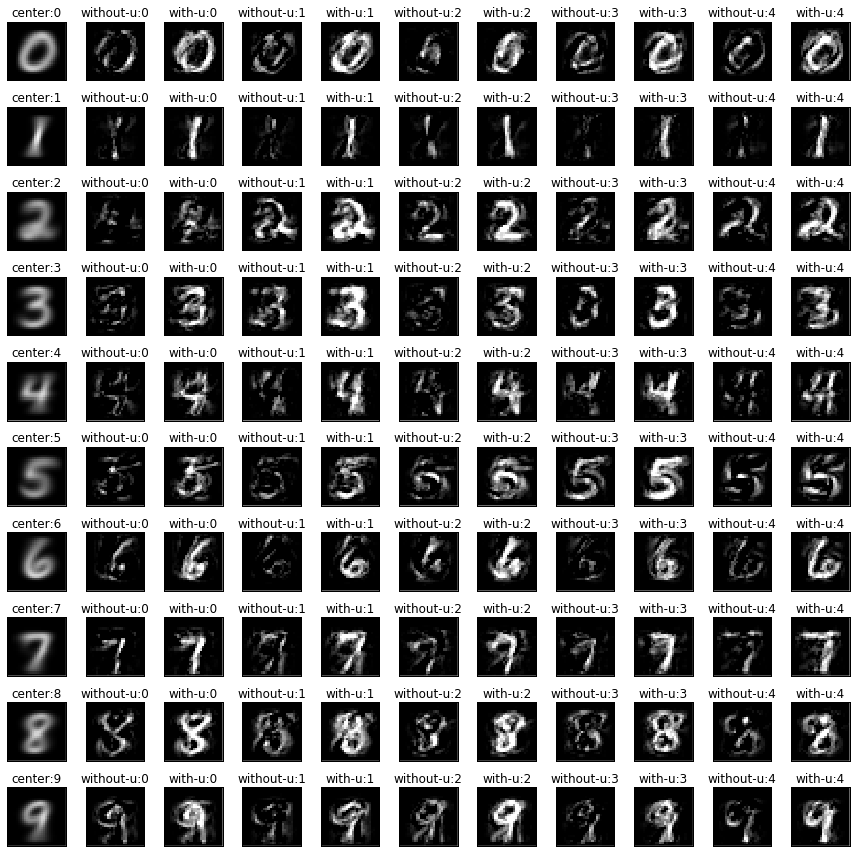

In [15]:
# Generate images from A and centers

cols = 10
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(10, (cols + 1), (cols + 1)*i + 1)
    plt.imshow(centers[i].reshape(28, 28), cmap="gray", vmin=0.0, vmax=1.0, interpolation="none")
    plt.title("center:"+str(i))
    plt.xticks([])
    plt.yticks([])
    
    A = As[i]
    u = centers[i][:, None]

    for j in range(5):
        plt.subplot(10, (cols + 1), (cols + 1)*i + j*2 + 2)
        x = np.random.standard_normal((784, 1))
        x = np.average(x, axis=1)
        x = x[:, None]

        d = np.dot(A, x) # + u
        img = d.reshape((28, 28))
        plt.subplot(10, (cols + 1), (cols + 1)*i + j*2 + 2)
        plt.imshow(img, cmap="gray", vmin=0.0, vmax=1.0, interpolation="none")
        plt.title("without-u:"+str(j))
        plt.xticks([])
        plt.yticks([])

        d = np.dot(A, x) + u
        img = d.reshape((28, 28))
        plt.subplot(10, (cols + 1), (cols + 1)*i + j*2 + 1 +  2)
        plt.imshow(img, cmap="gray", vmin=0.0, vmax=1.0, interpolation="none")
        plt.title("with-u:"+str(j))
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()

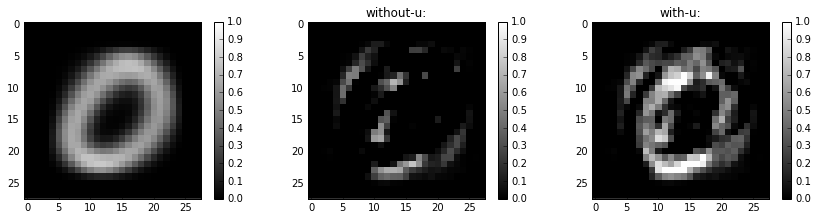

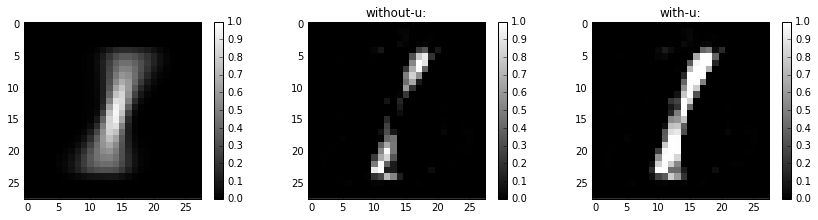

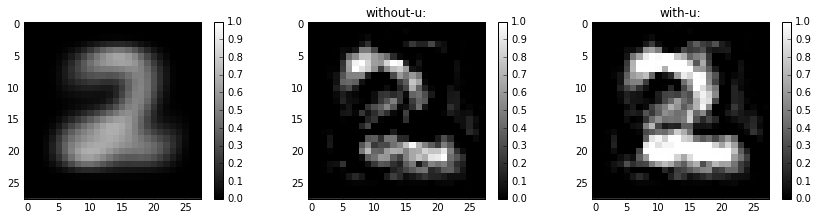

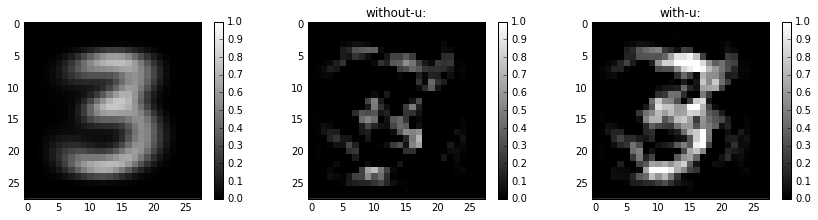

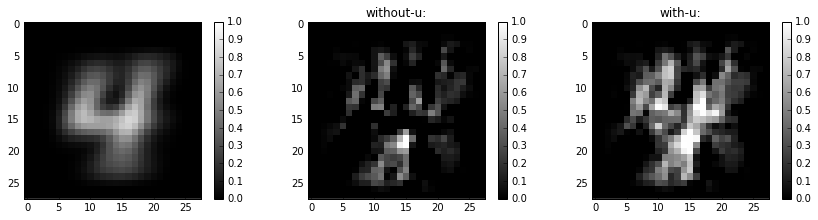

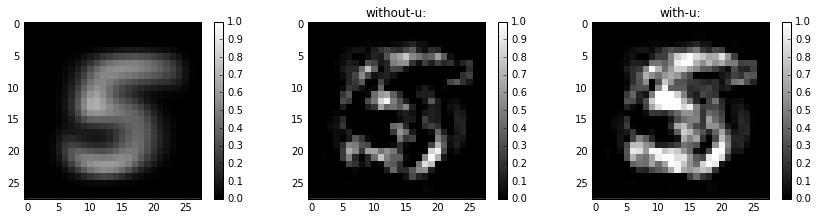

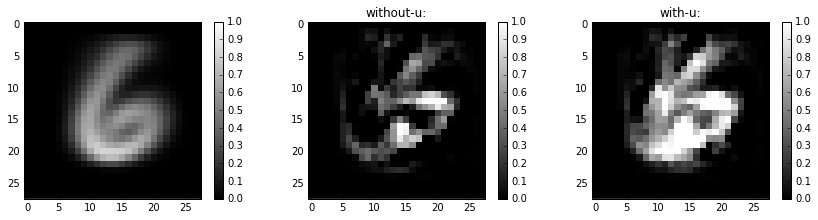

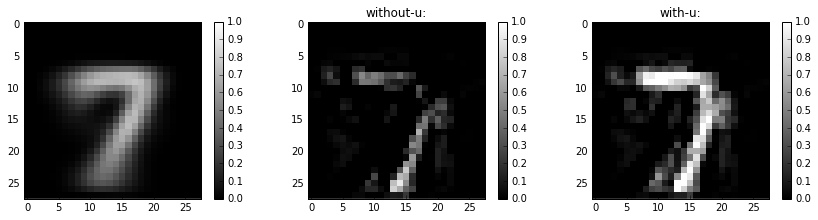

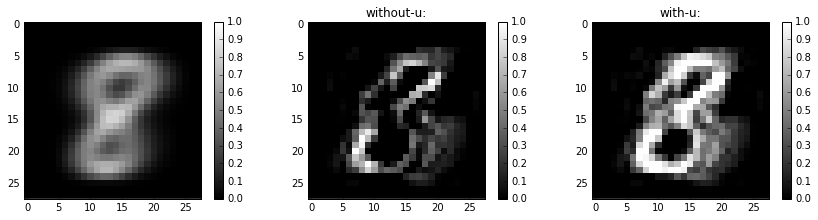

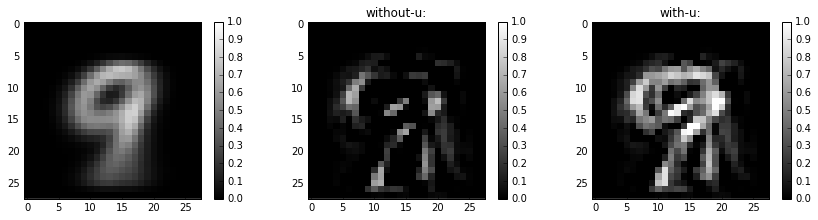

In [16]:
# Generate bigger images with colorbar from A and u

cols = 10
for i in range(10):
    plt.figure(figsize=(12, 3))
    plt.subplot(131)
    plt.imshow(centers[i].reshape(28, 28), cmap="gray", vmin=0.0, vmax=1.0, interpolation="none")
    plt.colorbar()
    
    A = As[i]
    u = centers[i][:, None]

    x = np.random.standard_normal((784, 1))
    x = np.average(x, axis=1)
    x = x[:, None]

    plt.subplot(132)
    d = np.dot(A, x) # + u
    img = d.reshape((28, 28))
    plt.imshow(img, cmap="gray", vmin=0.0, vmax=1.0, interpolation="none")
    plt.colorbar()
    plt.title("without-u:")
        
    plt.subplot(133)
    d = np.dot(A, x) + u
    img = d.reshape((28, 28))
    plt.imshow(img, cmap="gray", vmin=0.0, vmax=1.0, interpolation="none")
    plt.colorbar()
    plt.title("with-u:")

    plt.tight_layout()
    plt.show()

# Generate probability distribution function

- Probability distribution function can be generated from A and centers
- Some tricks are necessary to avoid singularity of matrix A
 - Select only linearly independent rows (bases)
 - Use pseude-inverse matrix instead of inverse matrix
 - Scale pseudo-inverse of matrix A to avoid det(A)=0 and/or det=inf
  - Actually det(A) should be pow(1/l, 1/d) to approximate distribution of x to N(0,1) <br>
    where l: mean of distance from center, d: dimention of A

i= 0  n= 4950
z0 : shape= (784, 4950) min= -0.788787 max= 0.999798 mean= -1.06652e-06 std= 0.252548 rank= 522 


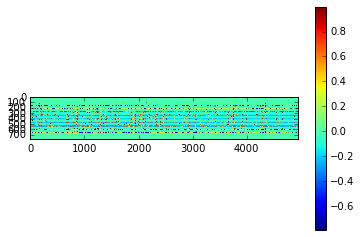

d0 : shape= (4950,) min= 25.5295 max= 122.312 mean= 50.0039 std= 11.8864 rank= 1 
cov : shape= (784, 784) min= -0.121196 max= 0.19758 mean= 0.00178741 std= 0.0161845 rank= 415 det= 0.0


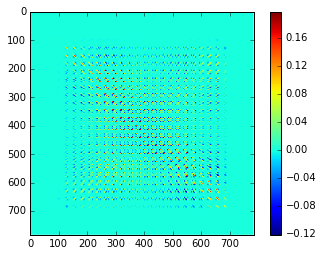

A : shape= (784, 784) min= -0.0588806 max= 0.278276 mean= 0.000989413 std= 0.00896514 rank= 530 det= -0.0


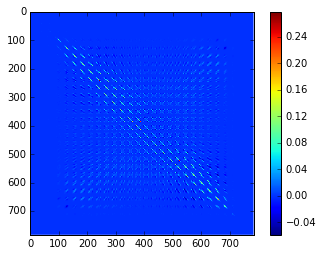

max(abs(A * A.T - cov))= 1.93715e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 96 max= 0.0588153
B : shape= (407, 407) min= -0.0588806 max= 0.278276 mean= 0.00361177 std= 0.0169688 rank= 407 det= 0.0


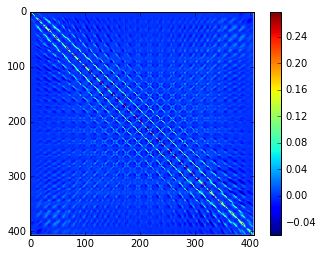

BPI : shape= (407, 407) min= -11.9632 max= 29.0744 mean= 0.00349561 std= 0.701125 rank= 407 det= inf


/home/itsukara/anaconda3/envs/tensorflow/lib/python3.5/site-packages/numpy/linalg/linalg.py:1776: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


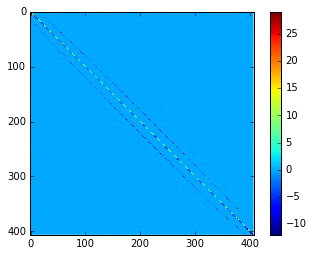

d0r= 0.9904340042670623
BPI : shape= (407, 407) min= -1.38458 max= 3.36498 mean= 0.00040457 std= 0.0811459 rank= 407 det= 0.019999


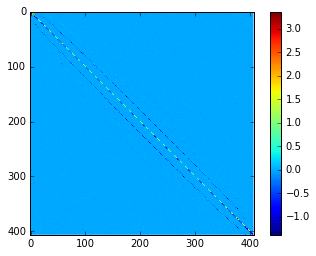

x : shape= (407, 4950) min= -1.28638 max= 2.43142 mean= -1.15539e-07 std= 0.116196 rank= 407 


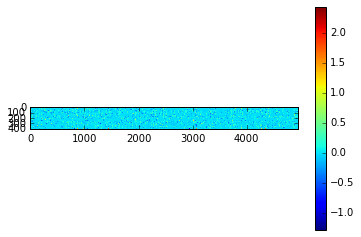

d : shape= (4950,) min= 2.19577 max= 23.9506 mean= 5.49508 std= 2.15149 rank= 1 
p : shape= (4950,) min= 1.09187955363e-125 max= 0.0358058254703 mean= 0.000850484924327 std= 0.00284925773233 rank= 1 
i= 1  n= 5623
z0 : shape= (784, 5623) min= -0.965245 max= 0.999646 mean= -5.21034e-07 std= 0.16927 rank= 471 


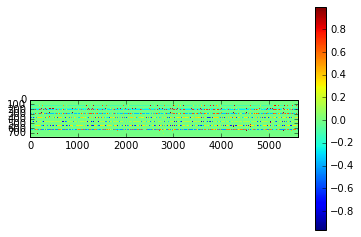

d0 : shape= (5623,) min= 9.89632 max= 95.1817 mean= 22.4634 std= 10.4256 rank= 1 
cov : shape= (784, 784) min= -0.132918 max= 0.200486 mean= 0.000481847 std= 0.0113221 rank= 272 det= 0.0


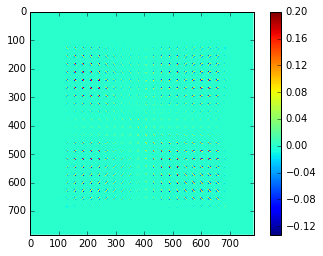

A : shape= (784, 784) min= -0.0448344 max= 0.260142 mean= 0.000425684 std= 0.00603035 rank= 504 det= -0.0


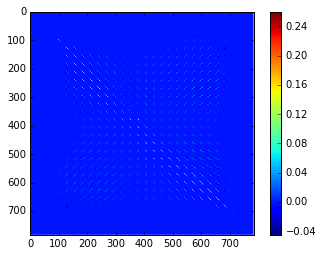

max(abs(A * A.T - cov))= 8.9407e-08
extract_base(threshold= 0.05 ) : n= 784 i1= 98 max= 0.0524006
B : shape= (243, 243) min= -0.0448344 max= 0.260142 mean= 0.0038216 std= 0.0189672 rank= 243 det= 0.0


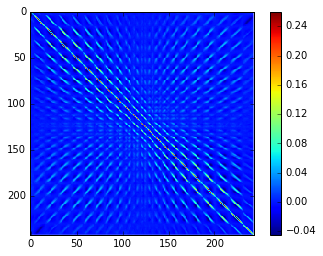

BPI : shape= (243, 243) min= -14.3529 max= 33.8577 mean= 0.0105312 std= 1.17308 rank= 243 det= inf


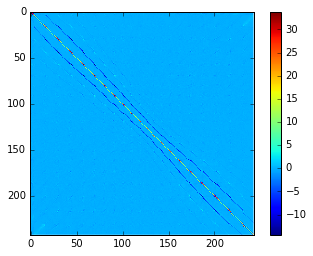

d0r= 0.9872755212342796
BPI : shape= (243, 243) min= -1.31997 max= 3.11372 mean= 0.000968502 std= 0.107883 rank= 243 det= 0.0445171


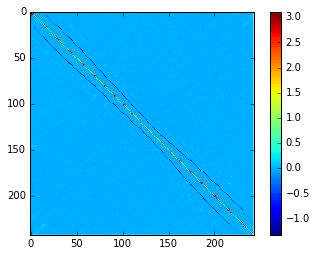

x : shape= (243, 5623) min= -1.44725 max= 1.90108 mean= -2.23445e-07 std= 0.0933406 rank= 243 


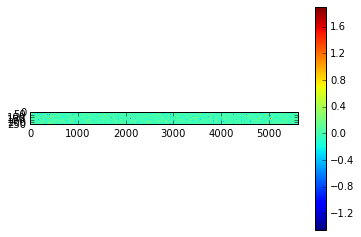

d : shape= (5623,) min= 0.324992 max= 18.2695 mean= 2.11713 std= 1.97638 rank= 1 
p : shape= (5623,) min= 1.32576777848e-73 max= 0.378420793693 mean= 0.145164081798 std= 0.112566542018 rank= 1 
i= 2  n= 4966
z0 : shape= (784, 4966) min= -0.69128 max= 0.999799 mean= -7.08136e-07 std= 0.254615 rank= 575 


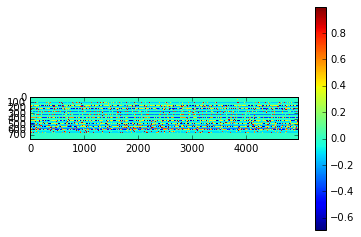

d0 : shape= (4966,) min= 29.1669 max= 108.744 mean= 50.8259 std= 10.364 rank= 1 
cov : shape= (784, 784) min= -0.111789 max= 0.199891 mean= 0.00144508 std= 0.0125953 rank= 475 det= 0.0


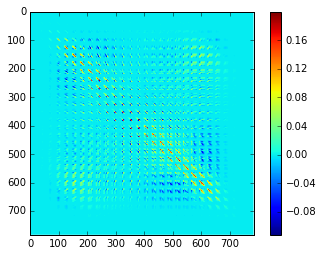

A : shape= (784, 784) min= -0.0534433 max= 0.283624 mean= 0.000915365 std= 0.00904722 rank= 584 det= 0.0


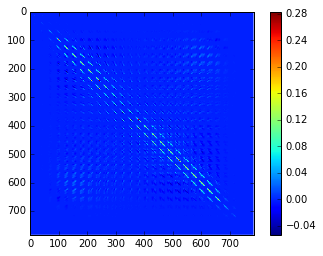

max(abs(A * A.T - cov))= 2.38419e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 66 max= 0.0561574
B : shape= (460, 460) min= -0.0534433 max= 0.283624 mean= 0.00262481 std= 0.0152547 rank= 460 det= 0.0


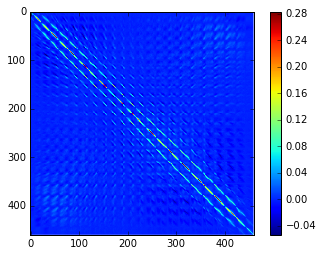

BPI : shape= (460, 460) min= -15.3936 max= 32.3619 mean= 0.00422132 std= 0.753269 rank= 460 det= inf


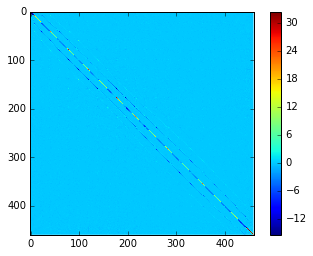

d0r= 0.9914963487706194
BPI : shape= (460, 460) min= -1.7593 max= 3.69859 mean= 0.000482447 std= 0.0860898 rank= 460 det= 0.0196755


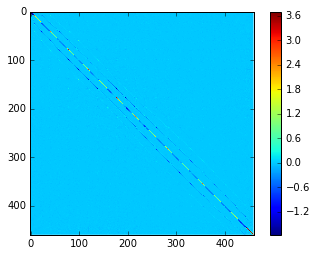

x : shape= (460, 4966) min= -1.50776 max= 2.45226 mean= -7.76932e-08 std= 0.114794 rank= 460 


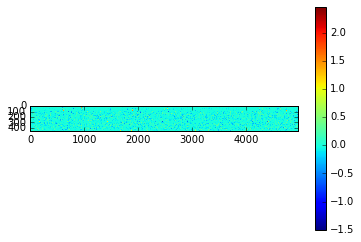

d : shape= (4966,) min= 2.28592 max= 24.4238 mean= 6.06169 std= 2.26726 rank= 1 
p : shape= (4966,) min= 1.17034292429e-130 max= 0.0292567730897 mean= 0.000256897157403 std= 0.00124177850278 rank= 1 
i= 3  n= 5107
z0 : shape= (784, 5107) min= -0.782216 max= 0.999658 mean= -7.73464e-07 std= 0.23932 rank= 547 


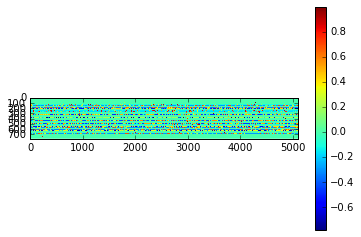

d0 : shape= (5107,) min= 22.3197 max= 125.896 mean= 44.9029 std= 12.2962 rank= 1 
cov : shape= (784, 784) min= -0.115472 max= 0.192751 mean= 0.00143197 std= 0.0117568 rank= 450 det= 0.0


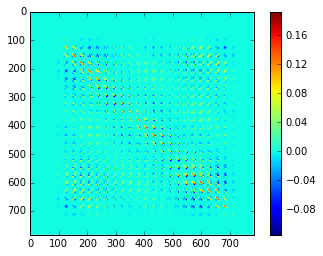

A : shape= (784, 784) min= -0.055009 max= 0.290107 mean= 0.000887084 std= 0.00850098 rank= 556 det= 0.0


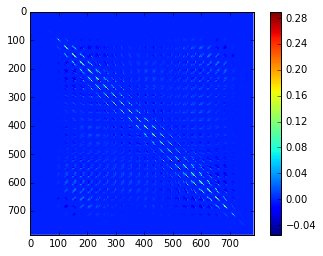

max(abs(A * A.T - cov))= 1.63913e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 94 max= 0.0587841
B : shape= (429, 429) min= -0.055009 max= 0.290107 mean= 0.00289817 std= 0.0153158 rank= 429 det= 0.0


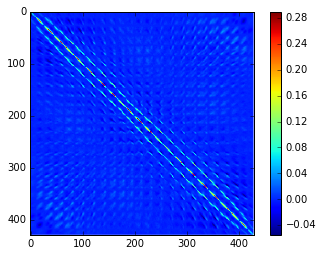

BPI : shape= (429, 429) min= -14.3873 max= 32.9413 mean= 0.00447632 std= 0.758006 rank= 429 det= inf


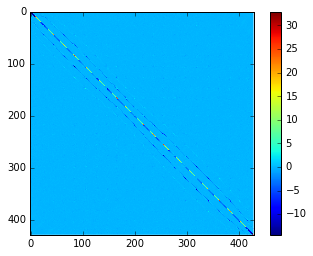

d0r= 0.9911709048410728
BPI : shape= (429, 429) min= -1.63018 max= 3.73249 mean= 0.000507199 std= 0.0858875 rank= 429 det= 0.0222715


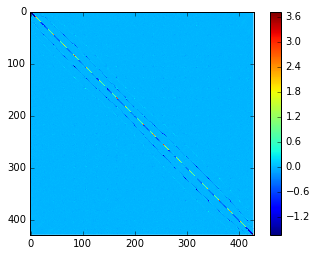

x : shape= (429, 5107) min= -1.41816 max= 2.45491 mean= -1.14638e-07 std= 0.114063 rank= 429 


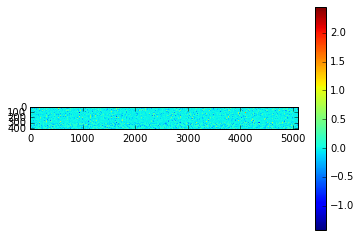

d : shape= (5107,) min= 2.02738 max= 22.503 mean= 5.58147 std= 2.44165 rank= 1 
p : shape= (5107,) min= 4.37790140111e-111 max= 0.0510948828073 mean= 0.00120408122262 std= 0.00377892944203 rank= 1 
i= 4  n= 4845
z0 : shape= (784, 4845) min= -0.842284 max= 0.999726 mean= -4.88741e-07 std= 0.228362 rank= 556 


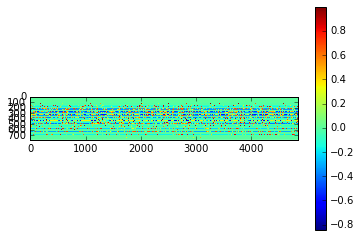

d0 : shape= (4845,) min= 21.3839 max= 124.602 mean= 40.8851 std= 11.4255 rank= 1 
cov : shape= (784, 784) min= -0.111008 max= 0.192774 mean= 0.00100834 std= 0.0107723 rank= 455 det= 0.0


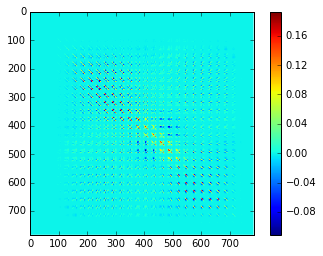

A : shape= (784, 784) min= -0.0544613 max= 0.284142 mean= 0.000734993 std= 0.00812261 rank= 564 det= -0.0


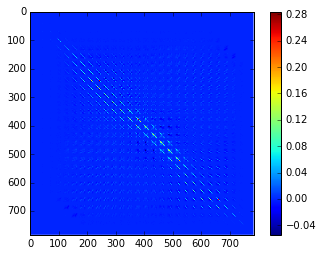

max(abs(A * A.T - cov))= 1.49012e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 103 max= 0.0501515
B : shape= (416, 416) min= -0.0544613 max= 0.284142 mean= 0.00251825 std= 0.0151166 rank= 416 det= 0.0


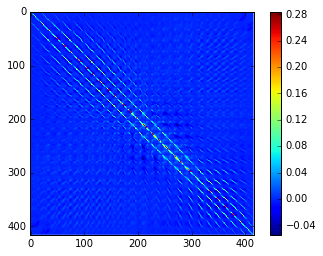

BPI : shape= (416, 416) min= -18.1402 max= 38.2167 mean= 0.00580213 std= 0.790214 rank= 416 det= inf


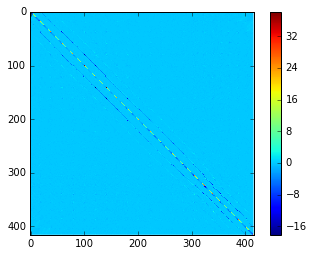

d0r= 0.9911195557884757
BPI : shape= (416, 416) min= -1.98406 max= 4.17991 mean= 0.000634601 std= 0.0864287 rank= 416 det= 0.0244568


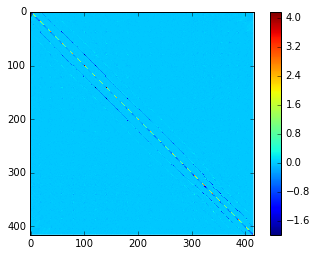

x : shape= (416, 4845) min= -1.56085 max= 2.09974 mean= -3.62418e-08 std= 0.110177 rank= 416 


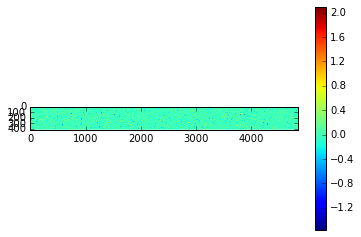

d : shape= (4845,) min= 1.55146 max= 28.2011 mean= 5.04981 std= 2.499 rank= 1 
p : shape= (4845,) min= 8.00682575868e-174 max= 0.119736775255 mean= 0.0032231656473 std= 0.00870380297652 rank= 1 
i= 5  n= 4529
z0 : shape= (784, 4529) min= -0.683169 max= 0.999779 mean= -3.77101e-07 std= 0.246391 rank= 554 


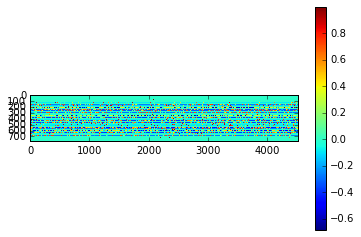

d0 : shape= (4529,) min= 26.5799 max= 114.04 mean= 47.5953 std= 11.9416 rank= 1 
cov : shape= (784, 784) min= -0.101838 max= 0.192793 mean= 0.0013968 std= 0.0138481 rank= 440 det= 0.0


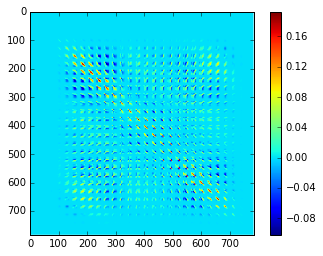

A : shape= (784, 784) min= -0.0472576 max= 0.291638 mean= 0.000880213 std= 0.00875553 rank= 560 det= -0.0


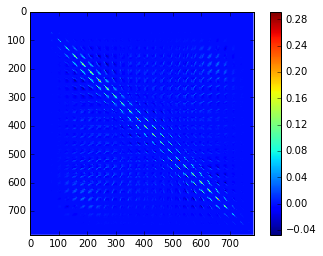

max(abs(A * A.T - cov))= 1.93715e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 99 max= 0.0542389
B : shape= (426, 426) min= -0.0472576 max= 0.291638 mean= 0.00289003 std= 0.0158907 rank= 426 det= 0.0


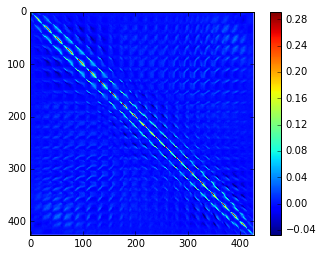

BPI : shape= (426, 426) min= -16.4038 max= 34.2632 mean= 0.00398793 std= 0.798721 rank= 426 det= inf


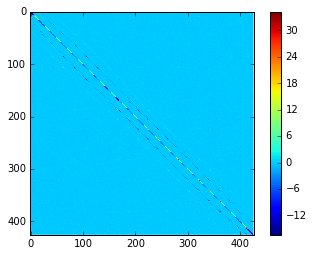

d0r= 0.9909735335581459
BPI : shape= (426, 426) min= -1.84002 max= 3.84332 mean= 0.000447327 std= 0.0895928 rank= 426 det= 0.0210096


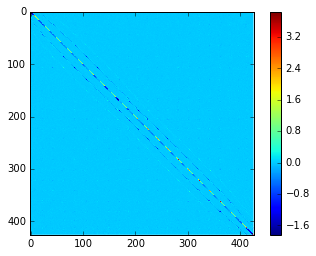

x : shape= (426, 4529) min= -1.59954 max= 2.42832 mean= -4.23762e-08 std= 0.112893 rank= 426 


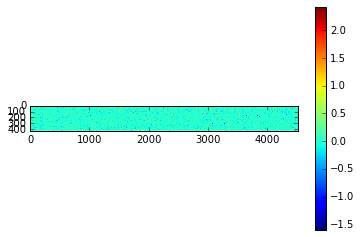

d : shape= (4529,) min= 1.77274 max= 25.3677 mean= 5.42928 std= 2.43868 rank= 1 
p : shape= (4529,) min= 7.27452726622e-141 max= 0.0828893536097 mean= 0.000952427045882 std= 0.00340024493573 rank= 1 
i= 6  n= 4905
z0 : shape= (784, 4905) min= -0.836617 max= 0.999335 mean= -6.83368e-07 std= 0.234532 rank= 518 


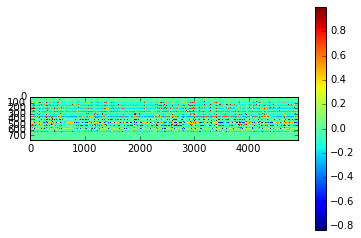

d0 : shape= (4905,) min= 22.5986 max= 119.071 mean= 43.1241 std= 13.4275 rank= 1 
cov : shape= (784, 784) min= -0.109096 max= 0.192157 mean= 0.0014032 std= 0.0131393 rank= 403 det= 0.0


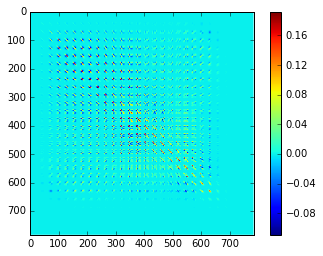

A : shape= (784, 784) min= -0.0505633 max= 0.296659 mean= 0.000842429 std= 0.00833367 rank= 531 det= 0.0


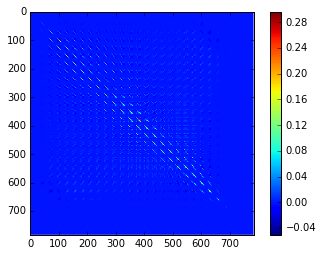

max(abs(A * A.T - cov))= 2.23517e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 39 max= 0.0543265
B : shape= (393, 393) min= -0.0505633 max= 0.296659 mean= 0.0032375 std= 0.0163402 rank= 393 det= 0.0


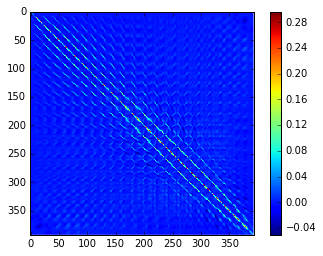

BPI : shape= (393, 393) min= -18.2021 max= 40.5775 mean= 0.0052771 std= 0.867756 rank= 393 det= inf


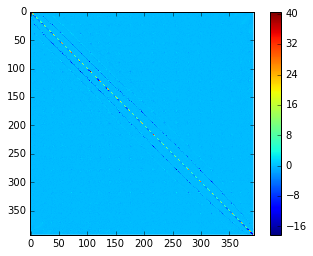

d0r= 0.9904679061923625
BPI : shape= (393, 393) min= -1.93486 max= 4.31334 mean= 0.00056095 std= 0.0922414 rank= 393 det= 0.023188


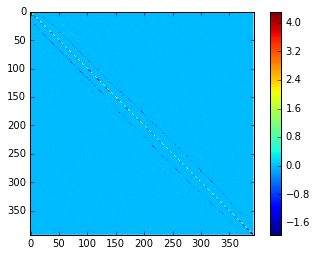

x : shape= (393, 4905) min= -1.28977 max= 2.58826 mean= -6.461e-08 std= 0.107102 rank= 393 


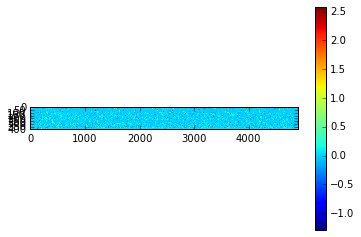

d : shape= (4905,) min= 1.22788 max= 20.7012 mean= 4.50805 std= 2.64752 rank= 1 
p : shape= (4905,) min= 3.50741983627e-94 max= 0.187722769142 mean= 0.0109507691312 std= 0.0207177569217 rank= 1 
i= 7  n= 5176
z0 : shape= (784, 5176) min= -0.771716 max= 0.999521 mean= -6.18103e-07 std= 0.218275 rank= 550 


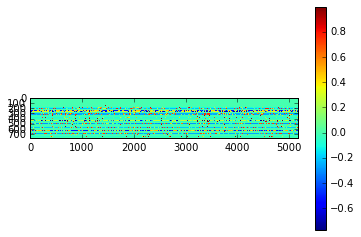

d0 : shape= (5176,) min= 17.5787 max= 112.485 mean= 37.353 std= 12.5432 rank= 1 
cov : shape= (784, 784) min= -0.112305 max= 0.194369 mean= 0.000957502 std= 0.0114232 rank= 426 det= 0.0


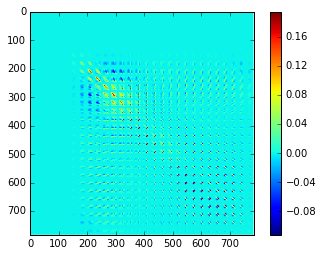

A : shape= (784, 784) min= -0.0501838 max= 0.276267 mean= 0.000700447 std= 0.00776401 rank= 555 det= -0.0


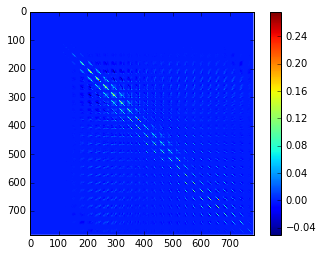

max(abs(A * A.T - cov))= 1.63913e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 149 max= 0.0565904
B : shape= (397, 397) min= -0.0501838 max= 0.276267 mean= 0.00261238 std= 0.0151113 rank= 397 det= 0.0


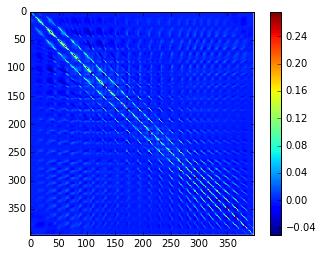

BPI : shape= (397, 397) min= -21.0209 max= 41.8177 mean= 0.00594357 std= 0.876161 rank= 397 det= inf


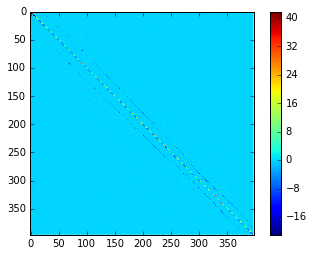

d0r= 0.9909220290834655
BPI : shape= (397, 397) min= -2.12594 max= 4.22922 mean= 0.000601101 std= 0.0886103 rank= 397 det= 0.0267708


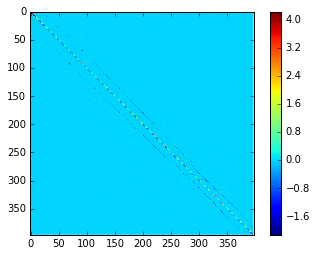

x : shape= (397, 5176) min= -1.62491 max= 2.31496 mean= -3.96637e-08 std= 0.102104 rank= 397 


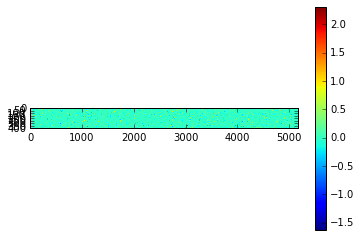

d : shape= (5176,) min= 1.10047 max= 20.4841 mean= 4.13879 std= 2.43133 rank= 1 
p : shape= (5176,) min= 3.06096387039e-92 max= 0.217738536931 mean= 0.0201218929733 std= 0.0360443145502 rank= 1 
i= 8  n= 4917
z0 : shape= (784, 4917) min= -0.833442 max= 0.999707 mean= -7.71134e-07 std= 0.241461 rank= 531 


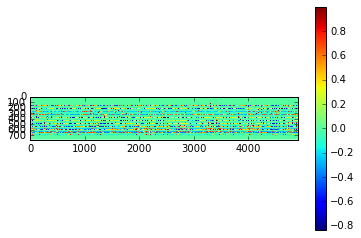

d0 : shape= (4917,) min= 23.6218 max= 130.547 mean= 45.71 std= 12.8855 rank= 1 
cov : shape= (784, 784) min= -0.0881177 max= 0.189567 mean= 0.00150707 std= 0.0111883 rank= 430 det= 0.0


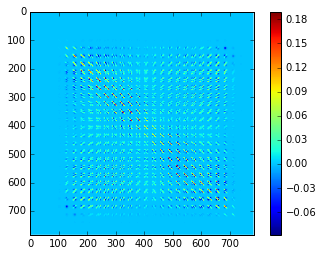

A : shape= (784, 784) min= -0.0513567 max= 0.306378 mean= 0.000915992 std= 0.00857484 rank= 543 det= 0.0


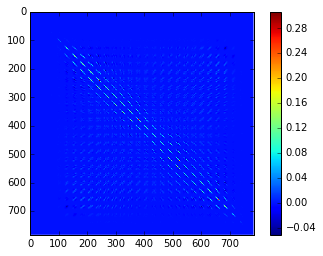

max(abs(A * A.T - cov))= 1.78814e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 122 max= 0.0664513
B : shape= (403, 403) min= -0.0513567 max= 0.306378 mean= 0.00336476 std= 0.0163898 rank= 403 det= 0.0


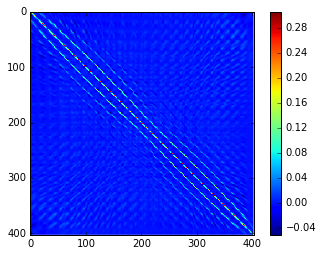

BPI : shape= (403, 403) min= -18.9657 max= 42.4552 mean= 0.00401063 std= 0.789277 rank= 403 det= inf


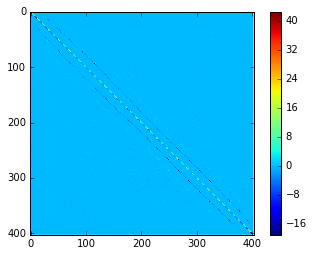

d0r= 0.9905601776992587
BPI : shape= (403, 403) min= -2.30651 max= 5.16318 mean= 0.000487751 std= 0.0959877 rank= 403 det= 0.0218755


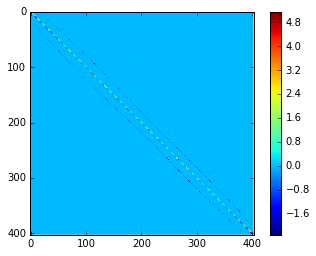

x : shape= (403, 4917) min= -1.59514 max= 2.79301 mean= -1.19045e-07 std= 0.122518 rank= 403 


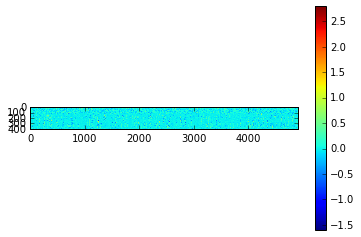

d : shape= (4917,) min= 1.89514 max= 30.3614 mean= 6.04934 std= 3.32493 rank= 1 
p : shape= (4917,) min= 2.69993044947e-201 max= 0.0662237137014 mean= 0.0013056089496 std= 0.00421887234603 rank= 1 
i= 9  n= 4982
z0 : shape= (784, 4982) min= -0.824006 max= 0.999797 mean= -5.70158e-07 std= 0.221835 rank= 511 


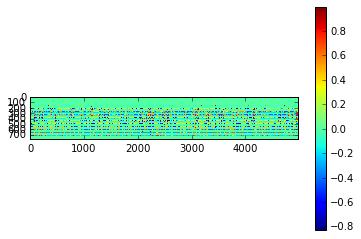

d0 : shape= (4982,) min= 20.8797 max= 126.457 mean= 38.5811 std= 13.3712 rank= 1 
cov : shape= (784, 784) min= -0.111462 max= 0.192398 mean= 0.00106273 std= 0.0114764 rank= 390 det= 0.0


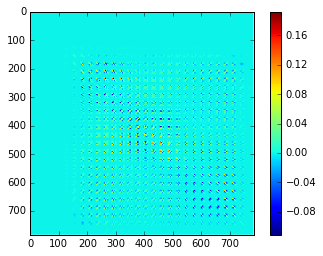

A : shape= (784, 784) min= -0.0625923 max= 0.300803 mean= 0.000734665 std= 0.00788853 rank= 523 det= 0.0


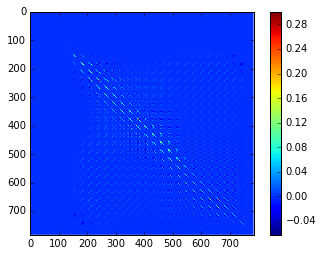

max(abs(A * A.T - cov))= 1.49012e-07
extract_base(threshold= 0.05 ) : n= 784 i1= 151 max= 0.0666302
B : shape= (369, 369) min= -0.0625923 max= 0.300803 mean= 0.00313338 std= 0.0164718 rank= 369 det= 0.0


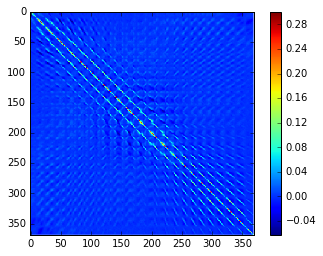

BPI : shape= (369, 369) min= -18.4861 max= 37.8805 mean= 0.00532023 std= 0.942439 rank= 369 det= inf


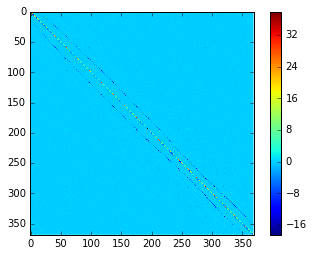

d0r= 0.9901497508152716
BPI : shape= (369, 369) min= -1.9353 max= 3.96568 mean= 0.000556971 std= 0.0986634 rank= 369 det= 0.0259168


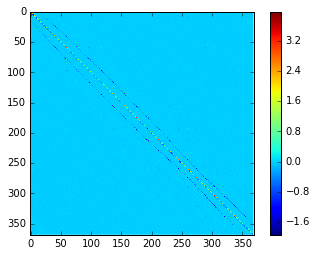

x : shape= (369, 4982) min= -1.45046 max= 2.4382 mean= -6.66332e-08 std= 0.105711 rank= 369 


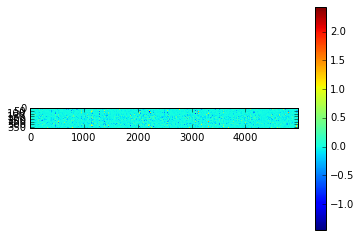

d : shape= (4982,) min= 1.15272 max= 21.6066 mean= 4.12349 std= 2.83409 rank= 1 
p : shape= (4982,) min= 1.68490638023e-102 max= 0.205291450386 mean= 0.0189934201907 std= 0.0301053661233 rank= 1 


In [17]:
# Calculate probability for each image in image-cluster using Variance-covariance matrix

covs = []
As = []
Bs = []
bindexes = []
BPIs = []
ps = []
for i in range(10):
    z = x_sample_of_chars[i]
    n = len(z)
    z = z.T
    u = centers[i]
    print("i=", i, " n=", n)
    
    z0 = z - u[:, None]
    print_stat(z0, "z0")
    d0 = np.sum(z0 * z0, axis=0)
    d0mean = np.mean(d0)
    print_stat(d0, "d0")
    
    # Calculate Variance-covariance matrix cov
    cov = np.dot(z0, z0.T)/n
    print_stat(cov, "cov")
    covs.append(cov)

    # Calculate A s.t. A * A.T = cov
    U, s, V = np.linalg.svd(cov, full_matrices=False)
    r = np.sqrt(s)
    A = np.dot(np.dot(U, np.diag(r)), V)
    print_stat(A, "A")
    As.append(A)

    # check if A * A.T = cov
    print("max(abs(A * A.T - cov))=", np.max(np.max(np.dot(A, A.T) - cov)))
    
    # extract only base rows
    B, index, rank = extract_base(A, 0.05)
    B = B[index,:]
    print_stat(B, "B")
    Bs.append(B)
    bindexes.append(index)
    
    # extract only base rows
    z0 = z0[index, :]
#    print_stat(z0, "z0")
    
    # calculate pseudo-inverse of B
    BPI = np.linalg.pinv(B)
    print_stat(BPI, "BPI")
    
    # scale BPI to be det(BPI) = 1/d0mean , because distribution of x should be N(0, 1)
    U, s, V = np.linalg.svd(BPI, full_matrices=False)
    s = s / scipy.stats.mstats.gmean(s) # necessary to avoid det(BPI)=0 or inf
    d0r = math.pow(1.0 / d0mean, 1.0 / len(s))
    s *= d0r # very slight effect
    print("d0r=", d0r)
    
    BPI = np.dot(np.dot(U, np.diag(s)), V)
    print_stat(BPI, "BPI")
    BPIs.append(BPI)
    
    x = np.dot(BPI, z0)
    print_stat(x, "x")

    d = np.sum(x * x, axis=0)
    print_stat(d, "d")

    p = scipy.stats.norm.pdf(d)
    print_stat(p, "p")
    ps.append(p)


i= 0 min= 1.09187955363e-125  max= 0.0358058254703
i= 1 min= 1.32576777848e-73  max= 0.378420793693
i= 2 min= 1.17034292429e-130  max= 0.0292567730897
i= 3 min= 4.37790140111e-111  max= 0.0510948828073
i= 4 min= 8.00682575868e-174  max= 0.119736775255
i= 5 min= 7.27452726622e-141  max= 0.0828893536097
i= 6 min= 3.50741983627e-94  max= 0.187722769142
i= 7 min= 3.06096387039e-92  max= 0.217738536931
i= 8 min= 2.69993044947e-201  max= 0.0662237137014
i= 9 min= 1.68490638023e-102  max= 0.205291450386


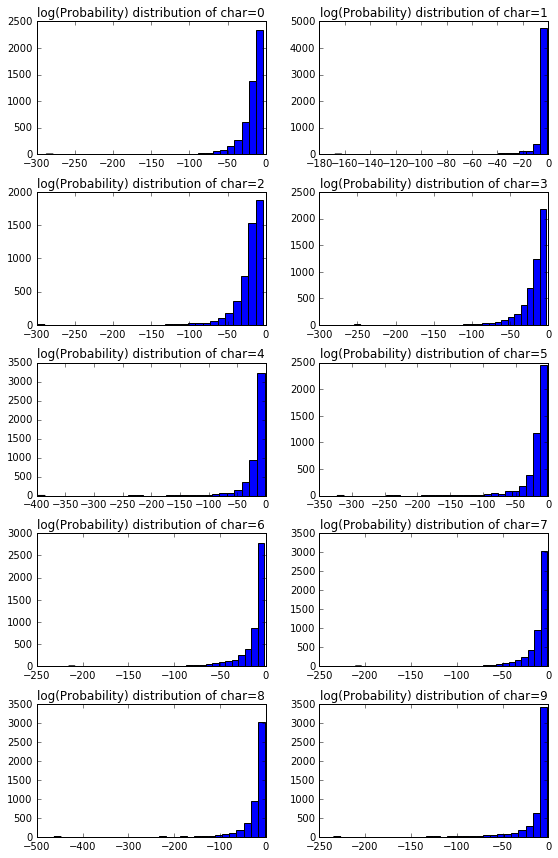

In [18]:
# Display histgrom of log(probability) in each image-cluster

plt.figure(figsize=(8, 12))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    p = ps[i] + np.exp(-500)
    print("i=", i ,"min=", np.min(p), " max=", np.max(p))
    plt.hist(np.log(p), bins=30)
#    plt.hist(p)
    plt.title("log(Probability) distribution of char="+str(i))
plt.tight_layout()
plt.show()

#  Check if each image-cluster is seperated by pdf
* pdf: probability distribution function

In [20]:
# Calculate ratio of data in cluster of which nearest center is its center
# Result: x% (x% - x%) of cluster member are nearest from the center

far_xs = []
nearest_centers = []
total_count = 0
total_ok_count = 0
for i in range(10):
  xi = x_sample_of_chars[i] 
 
  n = len(xi)
  z = xi.T
  pi = ps[i]
  i_is_nearest = np.ones(n)
  nearest_center  = np.ones(n, dtype=np.int) * i
  nearest_p = np.copy(pi)

  for j in range(10):
    if i == j:
      continue
    
    u = centers[j]
    z0 = z - u[:, None]
    index = bindexes[j]
    # extract only base rows
    z0 = z0[index, :]    

    BPI = BPIs[j]
    x = np.dot(BPI, z0)
    d = np.sum(x * x, axis=0)
    pj = scipy.stats.norm.pdf(d)
    
    i_is_near = (pi > pj).astype(np.int)
    i_is_nearest  = i_is_nearest  * i_is_near
    
    j_is_near = nearest_p < pj
    nearest_p[j_is_near] = pj[j_is_near]
    nearest_center[j_is_near] = j
    
  i_is_far = (np.ones_like(i_is_nearest) - i_is_nearest).astype(np.bool)
  far_x = x_sample_of_chars[i][i_is_far]
  far_xs.append(far_x)
  nearest_centers.append(nearest_center[i_is_far])
    
  ok_count  = np.sum(i_is_nearest )
  ok_ratio  = ok_count/n
  ng_count  = n - ok_count
  ng_ratio  = ng_count/n
  print("{}: ok={:.0f}({:.1f}%), ng={:.0f}({:.1f}%)".format(
        i, ok_count, ok_ratio*100, ng_count, ng_ratio*100))
  total_count += n
  total_ok_count += ok_count

total_ok_ratio = total_ok_count / total_count
total_ng_count = total_count - total_ok_count
total_ng_ratio = total_ng_count / total_count
print("OK={:.0f}/{:.0f}({:.1f}%), NG={:.0f}/{:.0f}({:.1f}%)".format(
      total_ok_count, total_count, total_ok_ratio*100, total_ng_count, total_count, total_ng_ratio*100))

0: ok=4853(98.0%), ng=97(2.0%)
1: ok=5191(92.3%), ng=432(7.7%)
2: ok=4827(97.2%), ng=139(2.8%)
3: ok=4779(93.6%), ng=328(6.4%)
4: ok=4699(97.0%), ng=146(3.0%)
5: ok=4243(93.7%), ng=286(6.3%)
6: ok=4683(95.5%), ng=222(4.5%)
7: ok=4872(94.1%), ng=304(5.9%)
8: ok=4642(94.4%), ng=275(5.6%)
9: ok=4631(93.0%), ng=351(7.0%)
OK=47420/50000(94.8%), NG=2580/50000(5.2%)


# of far data for char 0 = 97
# of far data for char 1 = 432
# of far data for char 2 = 139
# of far data for char 3 = 328
# of far data for char 4 = 146
# of far data for char 5 = 286
# of far data for char 6 = 222
# of far data for char 7 = 304
# of far data for char 8 = 275
# of far data for char 9 = 351


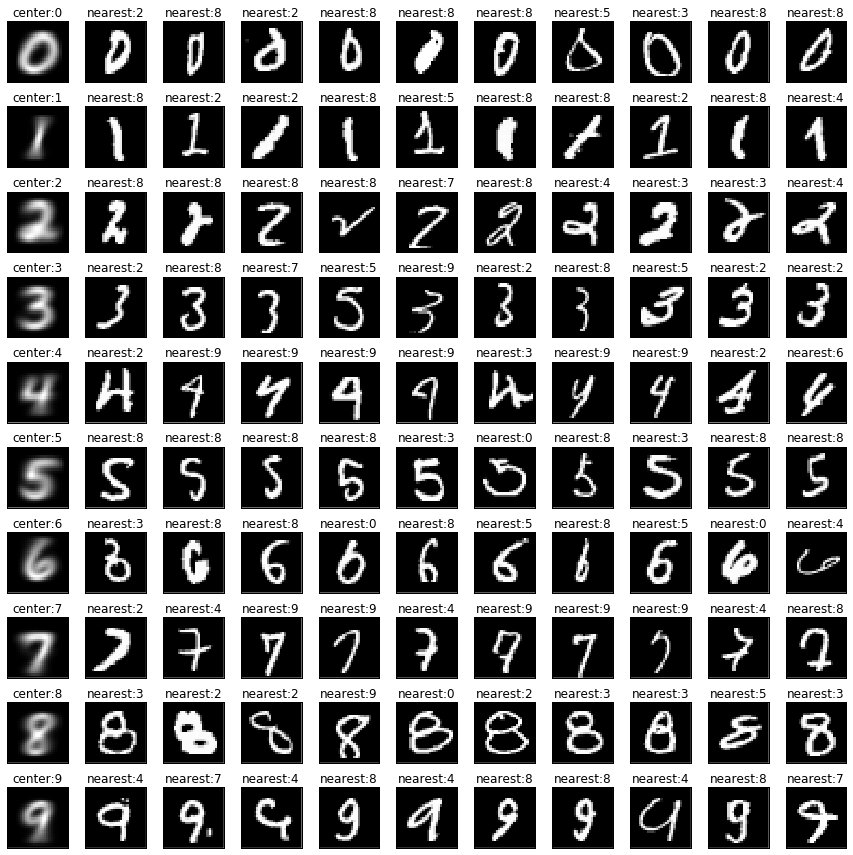

In [21]:
# Generate images far from center

cols = 10
offset = 0
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(10, (cols + 1), (cols + 1)*i + 1)
    plt.imshow(centers[i].reshape(28, 28), cmap="gray", interpolation="none")
    plt.title("center:"+str(i))
    plt.xticks([])
    plt.yticks([])

    len_far_i = len(far_xs[i])
    print("# of far data for char {} = {}".format(i, len_far_i))
    for j in range(offset, min(offset + cols, len_far_i)):
      plt.subplot(10, (cols + 1), (cols + 1)*i + j + 2)
      plt.imshow(far_xs[i][j].reshape(28, 28), cmap="gray", interpolation="none")
      plt.title("nearest:" + str(nearest_centers[i][j]))
      plt.xticks([])
      plt.yticks([])
plt.tight_layout()

# Try Classification of test data

In [22]:
# get test data

num_all_test = 10000
x_test, y_test = mnist.test.next_batch(num_all_test)

x_test_of_chars = []
for char in range(10):
    index = np.arange(num_all_test)[y_test[:,char] == 1]
    x_test_of_char = x_test[index]
    x_test_of_chars.append(x_test_of_char)

In [23]:
# Calculate ratio of data in cluster of which nearest center is its center
# Result: x% (x% - x%) of cluster member are nearest from the center

far_xs = []
nearest_centers = []
total_count = 0
total_ok_count = 0
for i in range(10):
  xi = x_test_of_chars[i] 
 
  n = len(xi)
  z = xi.T
#  pi = ps[i]

  u = centers[i]
  z0 = z - u[:, None]
  index = bindexes[i]
  # extract only base rows
  z0 = z0[index, :]  
    
  BPI = BPIs[i]
  x = np.dot(BPI, z0)
  d = np.sum(x * x, axis=0)
  pi = scipy.stats.norm.pdf(d)

  i_is_nearest = np.ones(n)
  nearest_center  = np.ones(n, dtype=np.int) * i
  nearest_p = np.copy(pi)

  for j in range(10):
    if i == j:
      continue
    
    u = centers[j]
    z0 = z - u[:, None]
    index = bindexes[j]
    # extract only base rows
    z0 = z0[index, :]   
    
    BPI = BPIs[j]
    x = np.dot(BPI, z0)
    d = np.sum(x * x, axis=0)
    pj = scipy.stats.norm.pdf(d)
    
    i_is_near = (pi > pj).astype(np.int)
    i_is_nearest  = i_is_nearest  * i_is_near
    
    j_is_near = nearest_p < pj
    nearest_p[j_is_near] = pj[j_is_near]
    nearest_center[j_is_near] = j
    
  i_is_far = (np.ones_like(i_is_nearest) - i_is_nearest).astype(np.bool)
  far_x = x_test_of_chars[i][i_is_far]
  far_xs.append(far_x)
  nearest_centers.append(nearest_center[i_is_far])
    
  ok_count  = np.sum(i_is_nearest )
  ok_ratio  = ok_count/n
  ng_count  = n - ok_count
  ng_ratio  = ng_count/n
  print("{}: ok={:.0f}({:.1f}%), ng={:.0f}({:.1f}%)".format(
        i, ok_count, ok_ratio*100, ng_count, ng_ratio*100))
  total_count += n
  total_ok_count += ok_count

total_ok_ratio = total_ok_count / total_count
total_ng_count = total_count - total_ok_count
total_ng_ratio = total_ng_count / total_count
print("OK={:.0f}/{:.0f}({:.1f}%), NG={:.0f}/{:.0f}({:.1f}%)".format(
      total_ok_count, total_count, total_ok_ratio*100, total_ng_count, total_count, total_ng_ratio*100))

0: ok=956(97.6%), ng=24(2.4%)
1: ok=1031(90.8%), ng=104(9.2%)
2: ok=981(95.1%), ng=51(4.9%)
3: ok=902(89.3%), ng=108(10.7%)
4: ok=945(96.2%), ng=37(3.8%)
5: ok=793(88.9%), ng=99(11.1%)
6: ok=876(91.4%), ng=82(8.6%)
7: ok=920(89.5%), ng=108(10.5%)
8: ok=879(90.2%), ng=95(9.8%)
9: ok=891(88.3%), ng=118(11.7%)
OK=9174/10000(91.7%), NG=826/10000(8.3%)


# of far data for char 0 = 24
# of far data for char 1 = 104
# of far data for char 2 = 51
# of far data for char 3 = 108
# of far data for char 4 = 37
# of far data for char 5 = 99
# of far data for char 6 = 82
# of far data for char 7 = 108
# of far data for char 8 = 95
# of far data for char 9 = 118


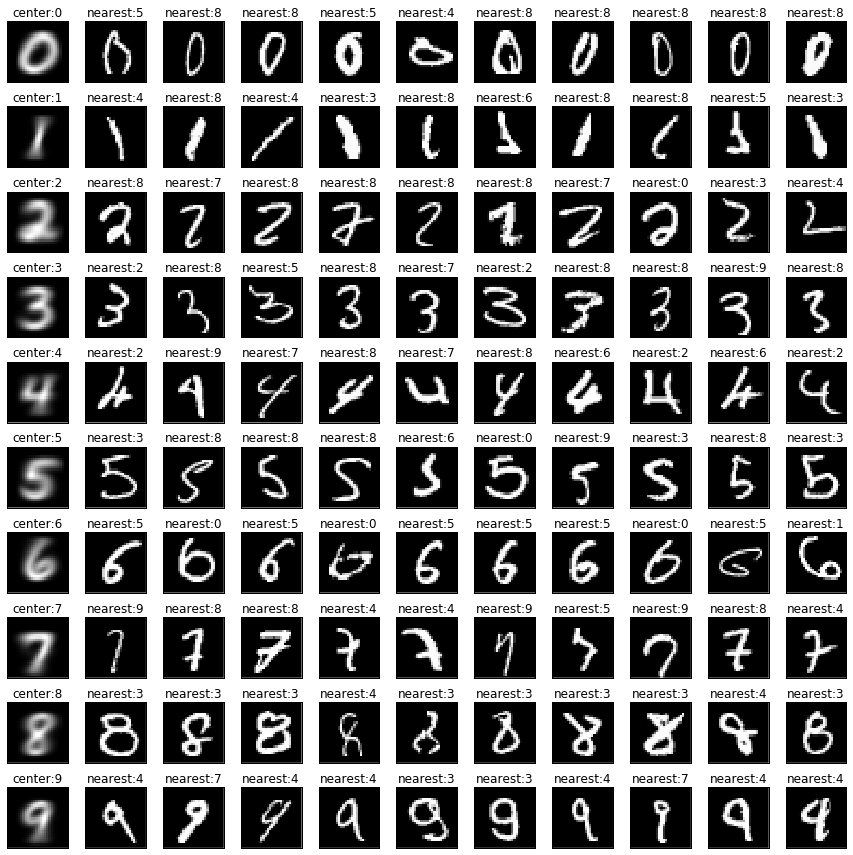

In [24]:
# Generate images far from center

cols = 10
offset = 0
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(10, (cols + 1), (cols + 1)*i + 1)
    plt.imshow(centers[i].reshape(28, 28), cmap="gray", interpolation="none")
    plt.title("center:"+str(i))
    plt.xticks([])
    plt.yticks([])

    len_far_i = len(far_xs[i])
    print("# of far data for char {} = {}".format(i, len_far_i))
    for j in range(offset, min(offset + cols, len_far_i)):
      plt.subplot(10, (cols + 1), (cols + 1)*i + j + 2)
      plt.imshow(far_xs[i][j].reshape(28, 28), cmap="gray", interpolation="none")
      plt.title("nearest:" + str(nearest_centers[i][j]))
      plt.xticks([])
      plt.yticks([])
plt.tight_layout()

Takayoshi Iitsuka 2016/10/5 
mail: iitt21-t@yahoo.co.jp